##Installing Dependencies

In [ ]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 45.8 MB/s eta 0:00:00


In [ ]:
!pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=52deb19ac974e41238617956647fce9ea43cb880c32447a0483a3f35c958b49f
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import random
import dgl
from ogb.nodeproppred import DglNodePropPredDataset
import dgl.function as fn
from torch import nn
import torch as t
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np

Modified LightGCN. Instead of learning shallow embeddings for each paper, we use
word2vec embeddings of the paper title and abstract to learn an MLP that
generates node embeddings for the paper.

In [ ]:
class LightGCN2(nn.Module):
    def __init__(self, args, userNum, item_feat_dim, hide_dim, layerNum=1):
        super(LightGCN2, self).__init__()
        self.userNum = userNum
        self.feat_dim = item_feat_dim
        self.hide_dim = hide_dim
        self.layerNum = layerNum
        self.item_mlp = nn.Sequential(
            nn.Linear(item_feat_dim, hide_dim),
            nn.ReLU(),
            nn.Linear(hide_dim, hide_dim)
        )
        self.embedding_dict = self.init_weight(userNum, hide_dim)
        self.args = args

        self.layers = nn.ModuleList()
        for i in range(self.layerNum):
            self.layers.append(GCNLayer())

    def init_weight(self, userNum, hide_dim):
        initializer = nn.init.xavier_uniform_
        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(t.empty(userNum, hide_dim))),
        })
        return embedding_dict


    def forward(self, graph, item_feat):

        res_user_embedding = self.embedding_dict['user_emb']
        # detach the item_feat
        item_feat = item_feat.detach()
        res_item_embedding = self.item_mlp(item_feat)

        for i, layer in enumerate(self.layers):
            if i == 0:
                embeddings = layer(graph, res_user_embedding, res_item_embedding)
            else:
                embeddings = layer(graph, embeddings[: self.userNum], embeddings[self.userNum: ])

            res_user_embedding = res_user_embedding + embeddings[: self.userNum]*(1/(i+2))
            res_item_embedding = res_item_embedding + embeddings[self.userNum: ]*(1/(i+2))

        user_embedding = res_user_embedding

        item_embedding = res_item_embedding

        return user_embedding, item_embedding




The original LightGCN implementation we modify:

In [ ]:
# Taken from https://github.com/xhcgit/LightGCN-implicit-DGL
class LightGCN(nn.Module):
    def __init__(self, args, userNum, itemNum, hide_dim, layerNum=1):
        super(LightGCN, self).__init__()
        self.userNum = userNum
        self.itemNum = itemNum
        self.hide_dim = hide_dim
        self.layerNum = layerNum
        self.embedding_dict = self.init_weight(userNum, itemNum, hide_dim)
        self.args = args

        self.layers = nn.ModuleList()
        for i in range(self.layerNum):
            self.layers.append(GCNLayer())

    def init_weight(self, userNum, itemNum, hide_dim):
        initializer = nn.init.xavier_uniform_
        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(t.empty(userNum, hide_dim))),
            'item_emb': nn.Parameter(initializer(t.empty(itemNum, hide_dim))),
        })
        return embedding_dict


    def forward(self, graph):

        res_user_embedding = self.embedding_dict['user_emb']
        res_item_embedding = self.embedding_dict['item_emb']

        for i, layer in enumerate(self.layers):
            if i == 0:
                embeddings = layer(graph, res_user_embedding, res_item_embedding)
            else:
                embeddings = layer(graph, embeddings[: self.userNum], embeddings[self.userNum: ])

            res_user_embedding = res_user_embedding + embeddings[: self.userNum]*(1/(i+2))
            res_item_embedding = res_item_embedding + embeddings[self.userNum: ]*(1/(i+2))

        user_embedding = res_user_embedding

        item_embedding = res_item_embedding

        return user_embedding, item_embedding




We use the following implementation of GCNLayer, unmodified:

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self):
        super(GCNLayer, self).__init__()

    def forward(self, graph, u_f, v_f):
        with graph.local_scope():
            node_f = t.cat([u_f, v_f], dim=0)
            degs = graph.out_degrees().to(u_f.device).float().clamp(min=1)
            norm = t.pow(degs, -0.5).view(-1, 1)

            node_f = node_f * norm

            graph.ndata['n_f'] = node_f
            graph.update_all(message_func=fn.copy_u(u='n_f', out='m'), reduce_func=fn.sum(msg='m', out='n_f'))

            rst = graph.ndata['n_f']

            degs = graph.in_degrees().to(u_f.device).float().clamp(min=1)
            norm = t.pow(degs, -0.5).view(-1, 1)
            rst = rst * norm

            return rst

We create two recall metrics:
1. Recall@K for edges from author to paper: This the fraction of predicted top K author-paper that are positive edges in the test set. Averaged over authors.
2. Recall@K for paper-author direction: Since we are doing co-author prediction, we also calculate the fraction of top K predicted authors for each paper that match the ground truth. Averaged over papers.

In [ ]:
def recallK_author_to_paper(valid_authors, pos_score, valid_pos_u, neg_score, valid_neg_u, k):
    # u is author, v is paper
    recs = []
    for author in tqdm(valid_authors):
        pos_papers = (valid_pos_u == author)
        neg_papers = (valid_neg_u == author)
        curr_pos_score = pos_score[pos_papers]
        curr_neg_score = neg_score[neg_papers]

        num_pos = curr_pos_score.shape[0]
        all_scores = t.cat([curr_pos_score, curr_neg_score], dim=0)

        # assert all_scores.shape == (t.sum(pos_papers) + t.sum(neg_papers),)
        if k > all_scores.shape[0]:
            continue

        topk_indices = t.topk(all_scores, k)[1]
        recs.append((topk_indices < num_pos).sum() / num_pos)
    print(f"Fraction of authors used {len(recs)/valid_authors.shape[0]}")
    return np.mean(recs)

In [ ]:
def recallK(valid_papers, pos_score, valid_pos_v, neg_score, valid_neg_v, k_list):
    # u is author, v is paper
    recs = {k: [] for k in k_list}
    for paper in tqdm(valid_papers):
        pos_authors = (valid_pos_v == paper)
        neg_authors = (valid_neg_v == paper)
        curr_pos_score = pos_score[pos_authors]
        curr_neg_score = neg_score[neg_authors]

        num_pos = curr_pos_score.shape[0]
        all_scores = t.cat([curr_pos_score, curr_neg_score], dim=0)

        for k in k_list:
            # recall at k only makes sense if there are at least k positive examples
            if num_pos >= k:
                topk_indices = t.topk(all_scores, k)[1]
                recs[k].append((topk_indices < num_pos).sum() / num_pos)
            else:
                if k == 1:
                    pdb.set_trace()
                continue
    for k in k_list:
        print(f"Fraction of papers used for {k}: {len(recs[k])/valid_papers.shape[0]}")
    return {k: np.mean(recs[k]) for k in k_list}

To sample negative edges in a bipartite directed graph, we randomly replace either the head or the tail with a random node with equal probability.

In [ ]:
def sample_negative_edges(bipartite_graph, pos_u, pos_v):
    u = bipartite_graph.nodes('author')
    v = bipartite_graph.nodes('paper')

    # Sample negative edges
    negative_edges = []
    for i in range(len(pos_u)):
        # Randomly select a negative node
        negative_node = random.choice(v if i % 2 == 0 else u)

        # Append the negative edge
        negative_edges.append((pos_u[i], negative_node) if i % 2 == 0 else (negative_node, pos_v[i]))

    # Convert to DGL graph
    negative_edges = list(zip(*negative_edges))
    return t.tensor(negative_edges[0]), t.tensor(negative_edges[1])

In [ ]:
'''
generate similar author pairs. For each author, find similar authors based on
affiliation with the same institute. the model will try to bring these similar
authors closer, so that these authors are recommended more during co-author
prediction task: an author might want to collaborate more with similar authors
'''
def sample_positive_author_pairs(graph,anodes,num_samples):
        positive_pairs=t.zeros(num_samples,2,dtype=int)

        cfiller=0
        while cfiller<(positive_pairs.shape[0]):
            for source in anodes:
                institutions=graph.successors(source,etype='affiliated_with')
                if(len(institutions)==0):
                    continue
                institution=np.random.choice(institutions)
                writers=graph.predecessors(institution,etype='affiliated_with')
                for writer in writers:
                    if writer!=source and writer in anodes:
                        positive_pairs[cfiller,0]=source
                        positive_pairs[cfiller,1]=writer
                        cfiller+=1
                        break
                if cfiller==positive_pairs.shape[0]:
                        break
                if cfiller%10000==1:
                    print('Generated samples: {} of {}'.format(cfiller,num_samples))

        return positive_pairs

## Main Dataloading
1. We extract the subgraph contatining only ('author', 'writes', 'paper') relations.
2. We split edges into train/val/test in a 70/15/15 split. These are our positive edges.
3. To balance the positive edges, we sample an equal number of negative edges for each set.
4. We convert these into embedding ids, in order to extract embeddings during training.
5. We also extract the set of unique papers and authors for each of the validation and test set.
6. Now that we have extracted all necessary information from the directed heterogenous graph, we add reverse edges to make the graph undirected for GCN message passing, and homogenous.

In [ ]:
def load_data():
    print("Loading data...")
    # load ogb data
    dataset = DglNodePropPredDataset(name='ogbn-mag', root='data/dataset/')
    graph, label = dataset[0]
    _, feat_dim = graph.ndata['feat']['paper'].shape
    paper_feat = graph.ndata['feat']['paper']
    # graph2 is for author and institution: will be used to extract pairs of similar authors
    graph2=dgl.edge_type_subgraph(graph, [('author', 'affiliated_with', 'institution')])
    # only keep ("author", "writes", "paper") relation
    graph = dgl.edge_type_subgraph(graph, [('author', 'writes', 'paper')])
    # split edges into train/valid/test
    u, v = graph.edges()
    eids = t.randperm(graph.number_of_edges())
    train_percent, valid_percent = 0.7, 0.15
    train_size, valid_size, test_size = int(train_percent * len(eids)), int(valid_percent * len(eids)), len(eids) - int(train_percent * len(eids)) - int(valid_percent * len(eids))
    train_eids, valid_eids, test_eids = t.split(eids, [train_size, valid_size, test_size])
    print(f"train_size: {train_size}, valid_size: {valid_size}, test_size: {test_size}")
    neg_u, neg_v = sample_negative_edges(graph, u, v)
    train_pos_u, train_pos_v = u[train_eids], v[train_eids]
    valid_pos_u, valid_pos_v = u[valid_eids], v[valid_eids]
    test_pos_u, test_pos_v = u[test_eids], v[test_eids]
    train_neg_u, train_neg_v = neg_u[train_eids], neg_v[train_eids]
    valid_neg_u, valid_neg_v = neg_u[valid_eids], neg_v[valid_eids]
    test_neg_u, test_neg_v = neg_u[test_eids], neg_v[test_eids]

    author_ids = graph.nodes('author')
    paper_ids = graph.nodes('paper')

    # get the embedding ids
    train_pos_u = author_ids[train_pos_u]
    train_pos_v = paper_ids[train_pos_v]
    train_neg_u = author_ids[train_neg_u]
    train_neg_v = paper_ids[train_neg_v]
    valid_pos_u = author_ids[valid_pos_u]
    valid_pos_v = paper_ids[valid_pos_v]
    valid_neg_u = author_ids[valid_neg_u]
    valid_neg_v = paper_ids[valid_neg_v]
    test_pos_u = author_ids[test_pos_u]
    test_pos_v = paper_ids[test_pos_v]
    test_neg_u = author_ids[test_neg_u]
    test_neg_v = paper_ids[test_neg_v]

    unique_authors=t.unique(train_pos_u)
    similar_authors=sample_positive_author_pairs(graph2,unique_authors,len(unique_authors))

    valid_authors,b1=t.unique(valid_pos_u,return_counts=True)
    valid_papers,b1=t.unique(valid_pos_v,return_counts=True)

    test_authors,b1=t.unique(test_pos_u,return_counts=True)
    test_papers,b1=t.unique(test_pos_v,return_counts=True)

    # train graph
    train_graph = dgl.edge_subgraph(graph, train_eids, relabel_nodes=False)
    # valid graph
    valid_graph = dgl.edge_subgraph(graph, t.cat([train_eids, valid_eids], dim=0), relabel_nodes=False)
    # test graph
    test_graph = graph
    num_author = train_graph.number_of_nodes('author')
    num_paper = train_graph.number_of_nodes('paper')
    print(f"num_author: {num_author}, num_paper: {num_paper}")
    train_graph = dgl.to_homogeneous(train_graph)
    train_graph = dgl.add_reverse_edges(train_graph)
    valid_graph = dgl.to_homogeneous(valid_graph)
    valid_graph = dgl.add_reverse_edges(valid_graph)
    test_graph = dgl.to_homogeneous(test_graph)
    test_graph = dgl.add_reverse_edges(test_graph)

    return_dict = {
        'train_graph': train_graph,
        'valid_graph': valid_graph,
        'test_graph': test_graph,
        'train_pos_u': train_pos_u,
        'train_pos_v': train_pos_v,
        'train_neg_u': train_neg_u,
        'train_neg_v': train_neg_v,
        'similar_authors': similar_authors,
        'valid_pos_u': valid_pos_u,
        'valid_pos_v': valid_pos_v,
        'valid_neg_u': valid_neg_u,
        'valid_neg_v': valid_neg_v,
        'test_pos_u': test_pos_u,
        'test_pos_v': test_pos_v,
        'test_neg_u': test_neg_u,
        'test_neg_v': test_neg_v,
        'paper_feat': paper_feat,
        'num_author': num_author,
        'num_paper': num_paper,
        'feat_dim': feat_dim,
        'valid_authors': valid_authors,
        'test_authors': test_authors,
        'valid_papers': valid_papers,
        'test_papers': test_papers
    }
    return return_dict

Graph Visualisation

In [ ]:
dataset = DglNodePropPredDataset(name='ogbn-mag', root='data/dataset/')
graph, label = dataset[0]
print(graph.edges)

In [ ]:
data_dict = load_data()

# unpack data
train_graph = data_dict['train_graph']
valid_graph = data_dict['valid_graph']
test_graph = data_dict['test_graph']
paper_feat = data_dict['paper_feat']
train_pos_u = data_dict['train_pos_u']
train_pos_v = data_dict['train_pos_v']
positive_author_pairs=data_dict['similar_authors']
train_neg_u = data_dict['train_neg_u']
train_neg_v = data_dict['train_neg_v']
valid_pos_u = data_dict['valid_pos_u']
valid_pos_v = data_dict['valid_pos_v']
valid_neg_u = data_dict['valid_neg_u']
valid_neg_v = data_dict['valid_neg_v']
test_pos_u = data_dict['test_pos_u']
test_pos_v = data_dict['test_pos_v']
test_neg_u = data_dict['test_neg_u']
test_neg_v = data_dict['test_neg_v']
num_author = data_dict['num_author']
num_paper = data_dict['num_paper']
feat_dim = data_dict['feat_dim']
valid_authors = data_dict['valid_authors']
valid_papers = data_dict['valid_papers']
test_authors = data_dict['test_authors']
test_papers = data_dict['test_papers']

Loading data...
train_size: 5001962, valid_size: 1071849, test_size: 1071849
Generated samples: 1 of 928477
Generated samples: 10001 of 928477
Generated samples: 20001 of 928477
Generated samples: 30001 of 928477
Generated samples: 40001 of 928477
Generated samples: 50001 of 928477
Generated samples: 60001 of 928477
Generated samples: 70001 of 928477
Generated samples: 80001 of 928477
Generated samples: 90001 of 928477
Generated samples: 100001 of 928477
Generated samples: 110001 of 928477
Generated samples: 120001 of 928477
Generated samples: 130001 of 928477
Generated samples: 140001 of 928477
Generated samples: 150001 of 928477
Generated samples: 160001 of 928477
Generated samples: 170001 of 928477
Generated samples: 180001 of 928477
Generated samples: 190001 of 928477
Generated samples: 200001 of 928477
Generated samples: 210001 of 928477
Generated samples: 220001 of 928477
Generated samples: 230001 of 928477
Generated samples: 240001 of 928477
Generated samples: 250001 of 928477
G

In [ ]:
# Number of pairs of similar authors generated
print('generation done',positive_author_pairs.shape)

generation done torch.Size([928477, 2])


## Training and Evaluation

Regular BPR loss using only authors and papers (haven't used similar authors based on affiliation with same institute)

Number of layers: 1
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.6690763235092163
Valid Loss: 0.6767896413803101


 10%|█         | 1/10 [00:15<02:23, 15.92s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.338
Fraction of papers used for 4: 0.0564
Fraction of papers used for 6: 0.0264
Fraction of papers used for 8: 0.0168
Fraction of papers used for 10: 0.0118
Recall@10: {1: 0.5653891, 2: 0.59838784, 4: 0.51294255, 6: 0.41266412, 8: 0.33664826, 10: 0.25043026}
Epoch: 1
Loss: 0.6422837972640991
Valid Loss: 0.6645054221153259


 20%|██        | 2/10 [00:30<01:59, 14.96s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3424
Fraction of papers used for 4: 0.0496
Fraction of papers used for 6: 0.0242
Fraction of papers used for 8: 0.018
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.57059133, 2: 0.6118567, 4: 0.4936187, 6: 0.39517143, 8: 0.3813267, 10: 0.361578}
Epoch: 2
Loss: 0.6149930357933044
Valid Loss: 0.6512387990951538


 30%|███       | 3/10 [00:44<01:40, 14.43s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3456
Fraction of papers used for 4: 0.053
Fraction of papers used for 6: 0.022
Fraction of papers used for 8: 0.0144
Fraction of papers used for 10: 0.0118
Recall@10: {1: 0.55601, 2: 0.59469277, 4: 0.5337941, 6: 0.41424564, 8: 0.3486976, 10: 0.32541278}
Epoch: 3
Loss: 0.5679894089698792
Valid Loss: 0.6047011613845825


 40%|████      | 4/10 [00:58<01:27, 14.62s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3426
Fraction of papers used for 4: 0.057
Fraction of papers used for 6: 0.0248
Fraction of papers used for 8: 0.016
Fraction of papers used for 10: 0.0136
Recall@10: {1: 0.5512721, 2: 0.59825116, 4: 0.51852036, 6: 0.404573, 8: 0.31456262, 10: 0.2837073}
Epoch: 4
Loss: 0.5120518803596497
Valid Loss: 0.5489349365234375


 50%|█████     | 5/10 [01:13<01:13, 14.63s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.332
Fraction of papers used for 4: 0.0504
Fraction of papers used for 6: 0.0208
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0124
Recall@10: {1: 0.55053073, 2: 0.5918377, 4: 0.5201302, 6: 0.3587163, 8: 0.30142984, 10: 0.23054238}
Epoch: 5
Loss: 0.44685620069503784
Valid Loss: 0.48596903681755066


 60%|██████    | 6/10 [01:28<00:58, 14.59s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3428
Fraction of papers used for 4: 0.05
Fraction of papers used for 6: 0.0252
Fraction of papers used for 8: 0.02
Fraction of papers used for 10: 0.0168
Recall@10: {1: 0.54953516, 2: 0.5978159, 4: 0.5006285, 6: 0.37667337, 8: 0.35037965, 10: 0.3375167}
Epoch: 6
Loss: 0.3772397041320801
Valid Loss: 0.41995057463645935


 70%|███████   | 7/10 [01:42<00:43, 14.53s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3332
Fraction of papers used for 4: 0.0604
Fraction of papers used for 6: 0.027
Fraction of papers used for 8: 0.0196
Fraction of papers used for 10: 0.0162
Recall@10: {1: 0.5647981, 2: 0.603721, 4: 0.53966457, 6: 0.42826626, 8: 0.36613628, 10: 0.35826865}
Epoch: 7
Loss: 0.31413137912750244
Valid Loss: 0.3614838123321533


 80%|████████  | 8/10 [01:57<00:29, 14.54s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.347
Fraction of papers used for 4: 0.0532
Fraction of papers used for 6: 0.0228
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0114
Recall@10: {1: 0.58238995, 2: 0.6374603, 4: 0.58751565, 6: 0.47524807, 8: 0.41513848, 10: 0.3597341}
Epoch: 8
Loss: 0.2700711190700531
Valid Loss: 0.325809121131897


 90%|█████████ | 9/10 [02:12<00:14, 14.71s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3508
Fraction of papers used for 4: 0.06
Fraction of papers used for 6: 0.0242
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0126
Recall@10: {1: 0.5969999, 2: 0.6369632, 4: 0.581188, 6: 0.48847628, 8: 0.39008462, 10: 0.37190664}
Epoch: 9
Loss: 0.25581133365631104
Valid Loss: 0.3263969421386719


100%|██████████| 10/10 [02:26<00:00, 14.67s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.35
Fraction of papers used for 4: 0.0544
Fraction of papers used for 6: 0.0248
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0124
Recall@10: {1: 0.60363483, 2: 0.6533219, 4: 0.559837, 6: 0.4803027, 8: 0.44964778, 10: 0.40353778}


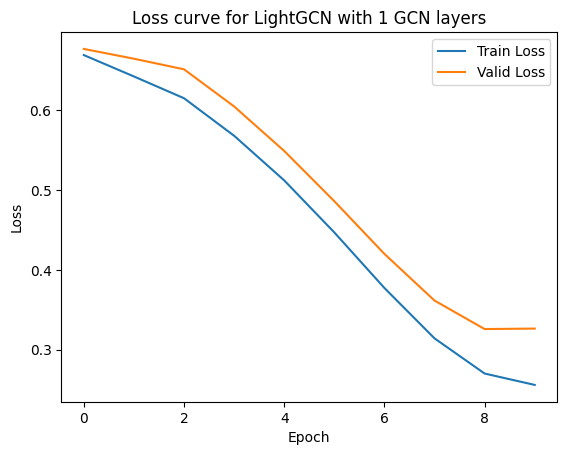

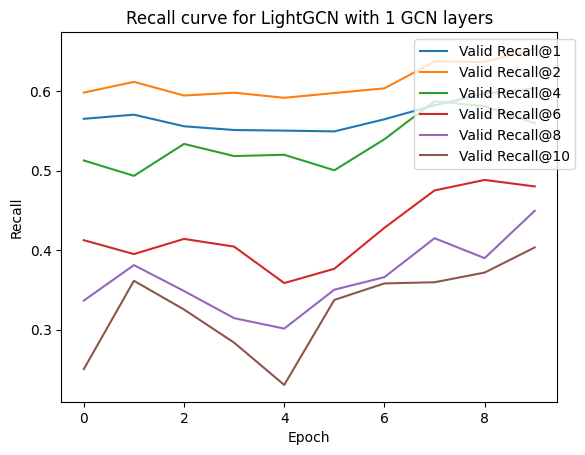

Test Loss: 0.3349897265434265


100%|██████████| 10000/10000 [00:14<00:00, 693.21it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3366
Fraction of papers used for 4: 0.051
Fraction of papers used for 6: 0.0237
Fraction of papers used for 8: 0.0166
Fraction of papers used for 10: 0.014
Recall@1: 0.6190263628959656
Recall@2: 0.6519082188606262
Recall@4: 0.5422969460487366
Recall@6: 0.44744744896888733
Recall@8: 0.3846839368343353
Recall@10: 0.3794350326061249
Number of layers: 2
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.6626725196838379
Valid Loss: 0.6739118099212646


 10%|█         | 1/10 [00:16<02:31, 16.87s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.35
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.0266
Fraction of papers used for 8: 0.0182
Fraction of papers used for 10: 0.0148
Recall@10: {1: 0.5704727, 2: 0.60681945, 4: 0.49439874, 6: 0.39963698, 8: 0.32695934, 10: 0.2796455}
Epoch: 1
Loss: 0.6216716170310974
Valid Loss: 0.6542273759841919


 20%|██        | 2/10 [00:33<02:14, 16.87s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3396
Fraction of papers used for 4: 0.0532
Fraction of papers used for 6: 0.0248
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0118
Recall@10: {1: 0.5639917, 2: 0.60031086, 4: 0.54668087, 6: 0.4611973, 8: 0.3533557, 10: 0.30817983}
Epoch: 2
Loss: 0.5766183733940125
Valid Loss: 0.629059910774231


 30%|███       | 3/10 [00:51<01:59, 17.06s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3438
Fraction of papers used for 4: 0.0558
Fraction of papers used for 6: 0.026
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.0148
Recall@10: {1: 0.55530035, 2: 0.5932352, 4: 0.48958302, 6: 0.421567, 8: 0.36925426, 10: 0.363219}
Epoch: 3
Loss: 0.5070897936820984
Valid Loss: 0.5591948628425598


 40%|████      | 4/10 [01:08<01:42, 17.10s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3436
Fraction of papers used for 4: 0.0474
Fraction of papers used for 6: 0.0216
Fraction of papers used for 8: 0.0144
Fraction of papers used for 10: 0.0116
Recall@10: {1: 0.55381405, 2: 0.61710244, 4: 0.53012395, 6: 0.47238478, 8: 0.41580597, 10: 0.39505395}
Epoch: 4
Loss: 0.4321264922618866
Valid Loss: 0.48105114698410034


 50%|█████     | 5/10 [01:25<01:25, 17.02s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3468
Fraction of papers used for 4: 0.0574
Fraction of papers used for 6: 0.025
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0124
Recall@10: {1: 0.5302078, 2: 0.5914703, 4: 0.55534834, 6: 0.45502862, 8: 0.4244749, 10: 0.35424763}
Epoch: 5
Loss: 0.3619627058506012
Valid Loss: 0.4086877703666687


 60%|██████    | 6/10 [01:41<01:07, 16.78s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3418
Fraction of papers used for 4: 0.055
Fraction of papers used for 6: 0.0232
Fraction of papers used for 8: 0.0152
Fraction of papers used for 10: 0.0108
Recall@10: {1: 0.53416574, 2: 0.59077436, 4: 0.5743598, 6: 0.5037593, 8: 0.4429246, 10: 0.38845924}
Epoch: 6
Loss: 0.3023689389228821
Valid Loss: 0.3500215709209442


 70%|███████   | 7/10 [01:57<00:50, 16.72s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3452
Fraction of papers used for 4: 0.0536
Fraction of papers used for 6: 0.0218
Fraction of papers used for 8: 0.0152
Fraction of papers used for 10: 0.0122
Recall@10: {1: 0.57124335, 2: 0.6166761, 4: 0.5614109, 6: 0.4654072, 8: 0.42779005, 10: 0.4080943}
Epoch: 7
Loss: 0.2550947070121765
Valid Loss: 0.3095497190952301


 80%|████████  | 8/10 [02:14<00:33, 16.75s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3526
Fraction of papers used for 4: 0.056
Fraction of papers used for 6: 0.0256
Fraction of papers used for 8: 0.0182
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.6073456, 2: 0.6419531, 4: 0.5634529, 6: 0.47650188, 8: 0.43415934, 10: 0.3856667}
Epoch: 8
Loss: 0.22917217016220093
Valid Loss: 0.29974162578582764


 90%|█████████ | 9/10 [02:32<00:17, 17.09s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3482
Fraction of papers used for 4: 0.0548
Fraction of papers used for 6: 0.0226
Fraction of papers used for 8: 0.0156
Fraction of papers used for 10: 0.013
Recall@10: {1: 0.6063999, 2: 0.6617519, 4: 0.57524663, 6: 0.4698007, 8: 0.4188774, 10: 0.41527477}
Epoch: 9
Loss: 0.2218908816576004
Valid Loss: 0.3145868480205536


100%|██████████| 10/10 [02:50<00:00, 17.01s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3494
Fraction of papers used for 4: 0.0548
Fraction of papers used for 6: 0.0238
Fraction of papers used for 8: 0.0158
Fraction of papers used for 10: 0.0128
Recall@10: {1: 0.60269964, 2: 0.6485747, 4: 0.56293225, 6: 0.4397101, 8: 0.344704, 10: 0.2968521}


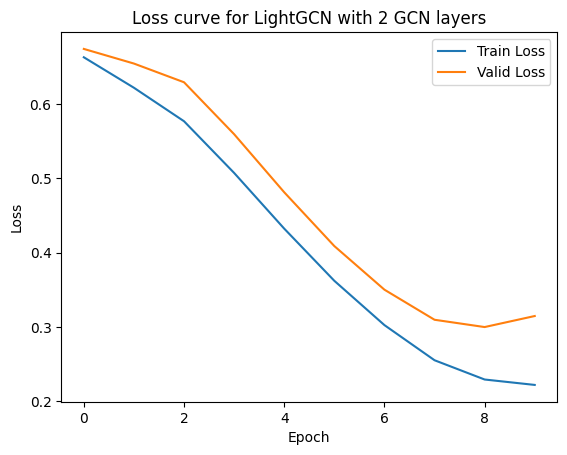

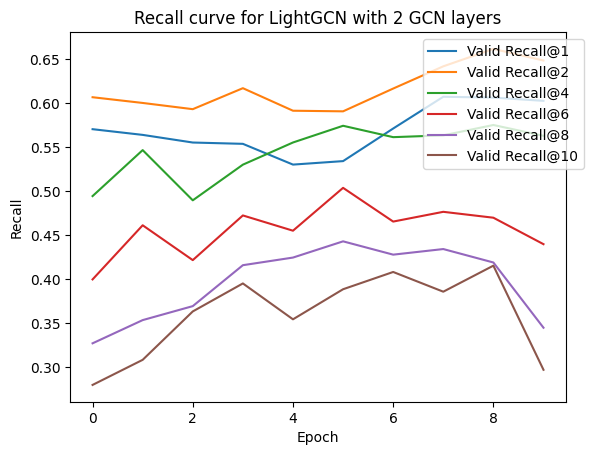

Test Loss: 0.32556167244911194


100%|██████████| 10000/10000 [00:14<00:00, 705.59it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3452
Fraction of papers used for 4: 0.0532
Fraction of papers used for 6: 0.0233
Fraction of papers used for 8: 0.0165
Fraction of papers used for 10: 0.0134
Recall@1: 0.6160460114479065
Recall@2: 0.6539178490638733
Recall@4: 0.5611693859100342
Recall@6: 0.45954832434654236
Recall@8: 0.4167206883430481
Recall@10: 0.4012736976146698
Number of layers: 4
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.6502649784088135
Valid Loss: 0.6707013845443726


 10%|█         | 1/10 [00:20<03:03, 20.44s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3432
Fraction of papers used for 4: 0.053
Fraction of papers used for 6: 0.0224
Fraction of papers used for 8: 0.0156
Fraction of papers used for 10: 0.0128
Recall@10: {1: 0.5737023, 2: 0.6118603, 4: 0.51582885, 6: 0.37521082, 8: 0.28912267, 10: 0.24356474}
Epoch: 1
Loss: 0.607469916343689
Valid Loss: 0.6566684246063232


 20%|██        | 2/10 [00:41<02:44, 20.56s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3522
Fraction of papers used for 4: 0.0552
Fraction of papers used for 6: 0.025
Fraction of papers used for 8: 0.0172
Fraction of papers used for 10: 0.0148
Recall@10: {1: 0.56274426, 2: 0.6039725, 4: 0.5218285, 6: 0.39547437, 8: 0.31293255, 10: 0.29792532}
Epoch: 2
Loss: 0.5326370596885681
Valid Loss: 0.5789530277252197


 30%|███       | 3/10 [01:03<02:28, 21.27s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3382
Fraction of papers used for 4: 0.049
Fraction of papers used for 6: 0.0236
Fraction of papers used for 8: 0.0186
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.563176, 2: 0.60760605, 4: 0.5106999, 6: 0.39653075, 8: 0.39010918, 10: 0.34464502}
Epoch: 3
Loss: 0.44636014103889465
Valid Loss: 0.4919719398021698


 40%|████      | 4/10 [01:25<02:11, 21.85s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3422
Fraction of papers used for 4: 0.055
Fraction of papers used for 6: 0.0252
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.55391306, 2: 0.6038569, 4: 0.5344406, 6: 0.4527298, 8: 0.41578332, 10: 0.37207028}
Epoch: 4
Loss: 0.3563941717147827
Valid Loss: 0.40436553955078125


 50%|█████     | 5/10 [01:46<01:47, 21.53s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3458
Fraction of papers used for 4: 0.0558
Fraction of papers used for 6: 0.023
Fraction of papers used for 8: 0.0152
Fraction of papers used for 10: 0.0116
Recall@10: {1: 0.5628084, 2: 0.6109197, 4: 0.5432584, 6: 0.48206526, 8: 0.42938855, 10: 0.3702949}
Epoch: 5
Loss: 0.27896973490715027
Valid Loss: 0.3342990279197693


 60%|██████    | 6/10 [02:08<01:26, 21.61s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3412
Fraction of papers used for 4: 0.0542
Fraction of papers used for 6: 0.0226
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.013
Recall@10: {1: 0.5949249, 2: 0.629771, 4: 0.5578413, 6: 0.44199607, 8: 0.37792465, 10: 0.39610955}
Epoch: 6
Loss: 0.24048158526420593
Valid Loss: 0.3184879720211029


 70%|███████   | 7/10 [02:30<01:05, 21.68s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3436
Fraction of papers used for 4: 0.053
Fraction of papers used for 6: 0.0236
Fraction of papers used for 8: 0.0144
Fraction of papers used for 10: 0.011
Recall@10: {1: 0.61577266, 2: 0.6563604, 4: 0.5745522, 6: 0.50422275, 8: 0.40880653, 10: 0.35999003}
Epoch: 7
Loss: 0.22832970321178436
Valid Loss: 0.32526397705078125


 80%|████████  | 8/10 [02:52<00:43, 21.75s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.36
Fraction of papers used for 4: 0.0544
Fraction of papers used for 6: 0.0244
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0136
Recall@10: {1: 0.61199737, 2: 0.64848435, 4: 0.55214053, 6: 0.4381281, 8: 0.38767412, 10: 0.32595795}
Epoch: 8
Loss: inf
Valid Loss: 0.32521629333496094


 90%|█████████ | 9/10 [03:15<00:22, 22.10s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3458
Fraction of papers used for 4: 0.0566
Fraction of papers used for 6: 0.0262
Fraction of papers used for 8: 0.0186
Fraction of papers used for 10: 0.0152
Recall@10: {1: 0.62054074, 2: 0.6513284, 4: 0.58064514, 6: 0.4843417, 8: 0.43764538, 10: 0.43582335}
Epoch: 9
Loss: nan
Valid Loss: nan


100%|██████████| 10/10 [03:33<00:00, 21.33s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.339
Fraction of papers used for 4: 0.0536
Fraction of papers used for 6: 0.0226
Fraction of papers used for 8: 0.0146
Fraction of papers used for 10: 0.013
Recall@10: {1: 0.80241644, 2: 0.83431524, 4: 0.6927679, 6: 0.5185193, 8: 0.38134056, 10: 0.39004436}


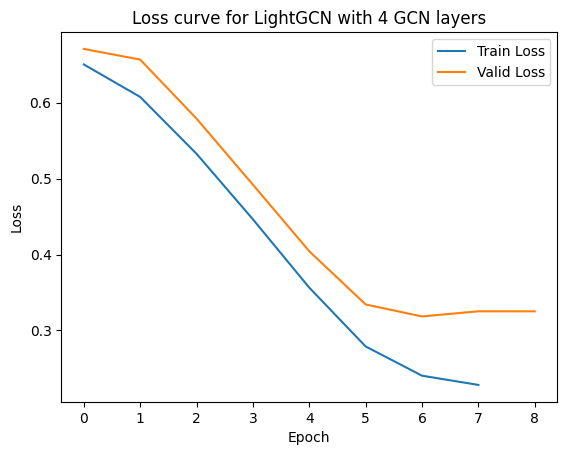

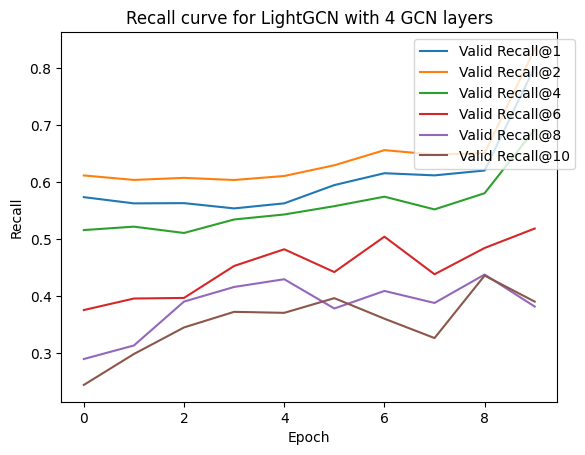

Test Loss: nan


100%|██████████| 10000/10000 [00:14<00:00, 685.97it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3502
Fraction of papers used for 4: 0.0558
Fraction of papers used for 6: 0.0233
Fraction of papers used for 8: 0.0152
Fraction of papers used for 10: 0.0112
Recall@1: 0.7964057326316833
Recall@2: 0.837269127368927
Recall@4: 0.7041210532188416
Recall@6: 0.5774648785591125
Recall@8: 0.5010591745376587
Recall@10: 0.4308641850948334
Number of layers: 8
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.6388182044029236
Valid Loss: 0.6707716584205627


 10%|█         | 1/10 [00:30<04:32, 30.30s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3516
Fraction of papers used for 4: 0.0588
Fraction of papers used for 6: 0.0246
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.0144
Recall@10: {1: 0.569771, 2: 0.5979715, 4: 0.52036166, 6: 0.37883818, 8: 0.32427546, 10: 0.29252157}
Epoch: 1
Loss: 0.5714168548583984
Valid Loss: 0.6155970692634583


 20%|██        | 2/10 [01:00<04:01, 30.25s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.333
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.0232
Fraction of papers used for 8: 0.0138
Fraction of papers used for 10: 0.0128
Recall@10: {1: 0.56556237, 2: 0.6140783, 4: 0.5462266, 6: 0.43253925, 8: 0.2848868, 10: 0.29945603}
Epoch: 2
Loss: 0.4824104905128479
Valid Loss: 0.5389711260795593


 30%|███       | 3/10 [01:30<03:32, 30.32s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3436
Fraction of papers used for 4: 0.052
Fraction of papers used for 6: 0.0244
Fraction of papers used for 8: 0.016
Fraction of papers used for 10: 0.0122
Recall@10: {1: 0.55534875, 2: 0.6130202, 4: 0.533065, 6: 0.46170717, 8: 0.36613578, 10: 0.299818}
Epoch: 3
Loss: 0.3774750232696533
Valid Loss: 0.42581236362457275


 40%|████      | 4/10 [02:00<03:01, 30.21s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3422
Fraction of papers used for 4: 0.0518
Fraction of papers used for 6: 0.0228
Fraction of papers used for 8: 0.0172
Fraction of papers used for 10: 0.0126
Recall@10: {1: 0.55509335, 2: 0.5997816, 4: 0.54137653, 6: 0.44229737, 8: 0.4110904, 10: 0.34017554}
Epoch: 4
Loss: 0.28680092096328735
Valid Loss: 0.3403201997280121


 50%|█████     | 5/10 [02:32<02:33, 30.70s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3466
Fraction of papers used for 4: 0.0556
Fraction of papers used for 6: 0.0254
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.59469616, 2: 0.6328953, 4: 0.5461394, 6: 0.45087472, 8: 0.3954629, 10: 0.3350929}
Epoch: 5
Loss: 0.2357468605041504
Valid Loss: 0.31432485580444336


 60%|██████    | 6/10 [03:03<02:02, 30.69s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3278
Fraction of papers used for 4: 0.0568
Fraction of papers used for 6: 0.0254
Fraction of papers used for 8: 0.0192
Fraction of papers used for 10: 0.0158
Recall@10: {1: 0.6159717, 2: 0.63183373, 4: 0.55456156, 6: 0.41713074, 8: 0.37659264, 10: 0.35387102}
Epoch: 6
Loss: 0.2155754268169403
Valid Loss: 0.31181594729423523


 70%|███████   | 7/10 [03:33<01:31, 30.55s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3464
Fraction of papers used for 4: 0.0542
Fraction of papers used for 6: 0.0226
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0134
Recall@10: {1: 0.6081234, 2: 0.6511153, 4: 0.56405705, 6: 0.43104577, 8: 0.41024682, 10: 0.36266363}
Epoch: 7
Loss: inf
Valid Loss: 0.311353862285614


 80%|████████  | 8/10 [04:04<01:01, 30.76s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3468
Fraction of papers used for 4: 0.0548
Fraction of papers used for 6: 0.0232
Fraction of papers used for 8: 0.0162
Fraction of papers used for 10: 0.012
Recall@10: {1: 0.6230521, 2: 0.65816927, 4: 0.58320606, 6: 0.48633555, 8: 0.44634888, 10: 0.37112102}
Epoch: 8
Loss: nan
Valid Loss: nan


 90%|█████████ | 9/10 [04:32<00:29, 29.91s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3386
Fraction of papers used for 4: 0.0558
Fraction of papers used for 6: 0.025
Fraction of papers used for 8: 0.018
Fraction of papers used for 10: 0.0138
Recall@10: {1: 0.8011513, 2: 0.82546514, 4: 0.67989796, 6: 0.51709825, 8: 0.46023488, 10: 0.39410275}
Epoch: 9
Loss: nan
Valid Loss: nan


100%|██████████| 10/10 [05:00<00:00, 30.05s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3312
Fraction of papers used for 4: 0.0506
Fraction of papers used for 6: 0.0204
Fraction of papers used for 8: 0.0142
Fraction of papers used for 10: 0.012
Recall@10: {1: 0.8067063, 2: 0.83276767, 4: 0.6935165, 6: 0.48323047, 8: 0.37834075, 10: 0.34203652}


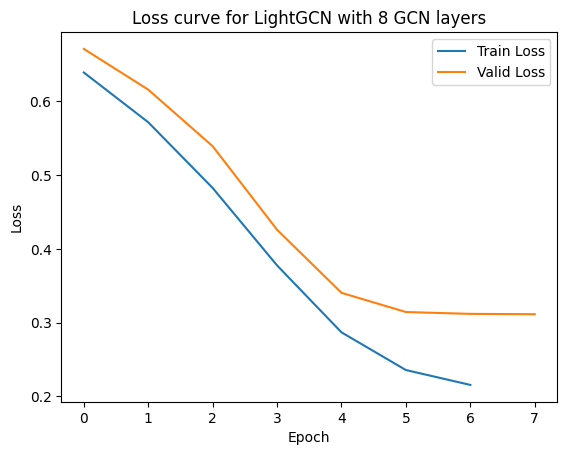

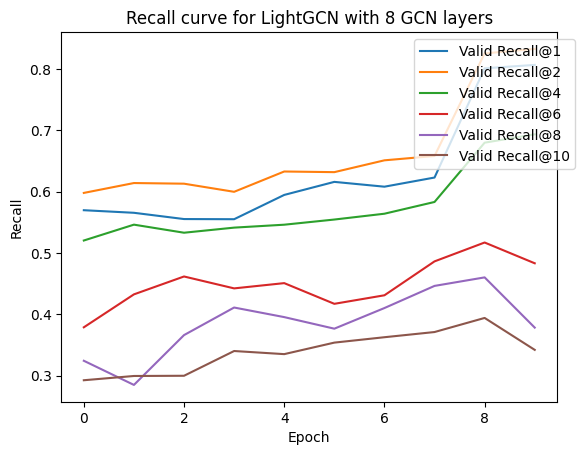

Test Loss: nan


100%|██████████| 10000/10000 [00:14<00:00, 674.89it/s]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3482
Fraction of papers used for 4: 0.0584
Fraction of papers used for 6: 0.0267
Fraction of papers used for 8: 0.0192
Fraction of papers used for 10: 0.0151
Recall@1: 0.7957017421722412
Recall@2: 0.8265465497970581
Recall@4: 0.6667868494987488
Recall@6: 0.5179973840713501
Recall@8: 0.46640586853027344
Recall@10: 0.4276576340198517


In [ ]:
num_layers_list=[1 ,2 ,4 ,8]
for num_layers in num_layers_list:
  print(f"Number of layers: {num_layers}")
  print("Training...")

  # model
  model = LightGCN2(None, num_author, feat_dim, 64, num_layers)
  # optimizer
  optimizer = t.optim.Adam(model.parameters(), lr=0.005)
  train_loss = []
  valid_loss = []
  valid_recall = {
      1: [],
      2: [],
      4: [],
      6: [],
      8: [],
      10: []
  }

  # train
  for epoch in tqdm(range(10)):
      print(f"Epoch: {epoch}")
      model.train()
      optimizer.zero_grad()
      author_embeddings, paper_embeddings = model(train_graph, paper_feat)

      # convert pos and neg ids to embeddings
      pos_author_embeddings = author_embeddings[train_pos_u]
      pos_paper_embeddings = paper_embeddings[train_pos_v]
      neg_author_embeddings = author_embeddings[train_neg_u]
      neg_paper_embeddings = paper_embeddings[train_neg_v]

      # BPR loss
      pos_score = t.sum(pos_author_embeddings * pos_paper_embeddings, dim=1)
      neg_score = t.sum(neg_author_embeddings * neg_paper_embeddings, dim=1)
      loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))

      loss.backward()
      optimizer.step()
      print(f"Loss: {loss.item()}")
      train_loss.append(loss.item())

      # validation
      model.eval()
      with t.no_grad():
          # cosine similarity
          pos_score = t.sum(author_embeddings[valid_pos_u] * paper_embeddings[valid_pos_v], dim=1)
          neg_score = t.sum(author_embeddings[valid_neg_u] * paper_embeddings[valid_neg_v], dim=1)
          loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))

          valid_loss.append(loss.item())
          print(f"Valid Loss: {loss.item()}")
          val_sample = random.sample(range(valid_papers.shape[0]), 5000)
          recK = recallK(valid_papers[val_sample], pos_score, valid_pos_v, neg_score, valid_neg_v, list(valid_recall.keys()))
          for k in valid_recall.keys():
              valid_recall[k].append(recK[k])
          print(f"Recall@{k}: {recK}")

  # plot loss
  plt.plot(train_loss, label='Train Loss')
  plt.plot(valid_loss, label='Valid Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss curve for LightGCN with {num_layers} GCN layers')
  plt.legend()
  plt.savefig(f'loss_{num_layers}.png')
  plt.show()
  plt.clf()
  for k in valid_recall.keys():
      plt.plot(valid_recall[k], label=f'Valid Recall@{k}')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.title(f'Recall curve for LightGCN with {num_layers} GCN layers')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
  plt.savefig(f'recall_{num_layers}.png')
  plt.show()

  # test
  model.eval()
  with t.no_grad():
      # recall K
      author_embeddings, paper_embeddings = model(valid_graph, paper_feat)
      # cosine similarity
      pos_score = t.sum(author_embeddings[test_pos_u] * paper_embeddings[test_pos_v], dim=1)
      neg_score = t.sum(author_embeddings[test_neg_u] * paper_embeddings[test_neg_v], dim=1)
      loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))
      print(f"Test Loss: {loss.item()}")
      test_sample = random.sample(range(test_papers.shape[0]), min(10000, test_papers.shape[0]))
      recK = recallK(test_papers[test_sample], pos_score, test_pos_v, neg_score, test_neg_v, list(valid_recall.keys()))
      for k in valid_recall.keys():
          print(f"Recall@{k}: {recK[k]}")

Augmented Loss: bringing similar authors closer

Number of layers: 1
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.9869527816772461
Valid Loss: 0.6756075024604797


 10%|█         | 1/10 [00:19<02:51, 19.08s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3334
Fraction of papers used for 4: 0.0526
Fraction of papers used for 6: 0.0226
Fraction of papers used for 8: 0.0146
Fraction of papers used for 10: 0.0114
Recall@10: {1: 0.5669254, 2: 0.59624374, 4: 0.5297845, 6: 0.39925942, 8: 0.29219565, 10: 0.239421}
Epoch: 1
Loss: 0.9203175902366638
Valid Loss: 0.6669198870658875


 20%|██        | 2/10 [00:34<02:14, 16.75s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3528
Fraction of papers used for 4: 0.06
Fraction of papers used for 6: 0.0254
Fraction of papers used for 8: 0.0172
Fraction of papers used for 10: 0.0136
Recall@10: {1: 0.56187624, 2: 0.6062041, 4: 0.52279115, 6: 0.4334756, 8: 0.3582569, 10: 0.31456953}
Epoch: 2
Loss: 0.8657864928245544
Valid Loss: 0.711616039276123


 30%|███       | 3/10 [00:48<01:50, 15.83s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3304
Fraction of papers used for 4: 0.0502
Fraction of papers used for 6: 0.0216
Fraction of papers used for 8: 0.0142
Fraction of papers used for 10: 0.012
Recall@10: {1: 0.57330203, 2: 0.6046664, 4: 0.5072994, 6: 0.39510006, 8: 0.29067606, 10: 0.25757664}
Epoch: 3
Loss: 0.8574061393737793
Valid Loss: 0.790469229221344


 40%|████      | 4/10 [01:03<01:32, 15.38s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3528
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.0254
Fraction of papers used for 8: 0.0188
Fraction of papers used for 10: 0.0152
Recall@10: {1: 0.5591936, 2: 0.59845537, 4: 0.48712683, 6: 0.35189956, 8: 0.30637708, 10: 0.2701029}
Epoch: 4
Loss: 0.8040660619735718
Valid Loss: 0.7305107712745667


 50%|█████     | 5/10 [01:18<01:16, 15.36s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3358
Fraction of papers used for 4: 0.0512
Fraction of papers used for 6: 0.026
Fraction of papers used for 8: 0.018
Fraction of papers used for 10: 0.0148
Recall@10: {1: 0.5613731, 2: 0.6009082, 4: 0.49030924, 6: 0.37610322, 8: 0.29561692, 10: 0.24721007}
Epoch: 5
Loss: 0.7491166591644287
Valid Loss: 0.6474542617797852


 60%|██████    | 6/10 [01:33<01:00, 15.22s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3466
Fraction of papers used for 4: 0.0602
Fraction of papers used for 6: 0.0272
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0154
Recall@10: {1: 0.5515292, 2: 0.5984645, 4: 0.5036919, 6: 0.41477478, 8: 0.31656063, 10: 0.305632}
Epoch: 6
Loss: 0.7048901319503784
Valid Loss: 0.5835200548171997


 70%|███████   | 7/10 [01:49<00:46, 15.44s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3346
Fraction of papers used for 4: 0.0568
Fraction of papers used for 6: 0.0232
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0122
Recall@10: {1: 0.5478002, 2: 0.5862398, 4: 0.575207, 6: 0.46900132, 8: 0.3698247, 10: 0.3548086}
Epoch: 7
Loss: 0.6600114703178406
Valid Loss: 0.5356627702713013


 80%|████████  | 8/10 [02:04<00:30, 15.31s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3432
Fraction of papers used for 4: 0.0506
Fraction of papers used for 6: 0.0212
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0118
Recall@10: {1: 0.5397982, 2: 0.59935135, 4: 0.5432326, 6: 0.4294144, 8: 0.4040182, 10: 0.35185835}
Epoch: 8
Loss: 0.6122940182685852
Valid Loss: 0.49890410900115967


 90%|█████████ | 9/10 [02:20<00:15, 15.40s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3446
Fraction of papers used for 4: 0.054
Fraction of papers used for 6: 0.0242
Fraction of papers used for 8: 0.0168
Fraction of papers used for 10: 0.0132
Recall@10: {1: 0.5384044, 2: 0.5947255, 4: 0.52808106, 6: 0.41306642, 8: 0.3653392, 10: 0.3274824}
Epoch: 9
Loss: 0.5684272050857544
Valid Loss: 0.474918931722641


100%|██████████| 10/10 [02:35<00:00, 15.53s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3438
Fraction of papers used for 4: 0.0544
Fraction of papers used for 6: 0.022
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0128
Recall@10: {1: 0.5332955, 2: 0.59952503, 4: 0.53415835, 6: 0.39378446, 8: 0.33365747, 10: 0.31139058}


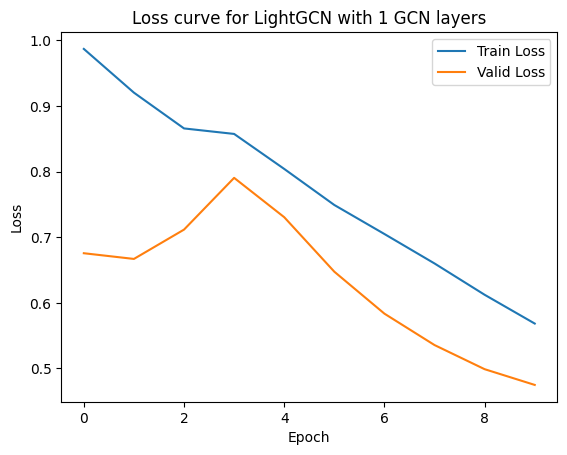

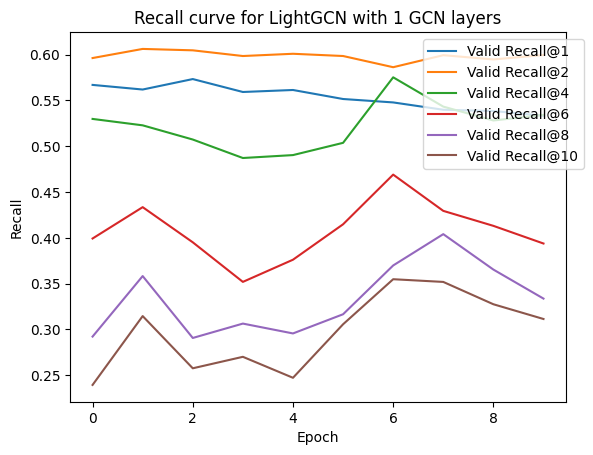

Test Loss: 0.4604901075363159


100%|██████████| 10000/10000 [00:14<00:00, 668.44it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3509
Fraction of papers used for 4: 0.0558
Fraction of papers used for 6: 0.0232
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.0152
Recall@1: 0.5414286851882935
Recall@2: 0.5943846702575684
Recall@4: 0.528718113899231
Recall@6: 0.3777672350406647
Recall@8: 0.32641133666038513
Recall@10: 0.3096870481967926
Number of layers: 2
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.9815987348556519
Valid Loss: 0.6745930314064026


 10%|█         | 1/10 [00:17<02:35, 17.29s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.366
Fraction of papers used for 4: 0.0592
Fraction of papers used for 6: 0.027
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0134
Recall@10: {1: 0.5612467, 2: 0.6018938, 4: 0.5344301, 6: 0.42974815, 8: 0.3149637, 10: 0.2679973}
Epoch: 1
Loss: 0.9077181220054626
Valid Loss: 0.6736480593681335


 20%|██        | 2/10 [00:34<02:18, 17.26s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3402
Fraction of papers used for 4: 0.056
Fraction of papers used for 6: 0.0256
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0136
Recall@10: {1: 0.5535565, 2: 0.58791363, 4: 0.51443374, 6: 0.40696752, 8: 0.35847306, 10: 0.3175786}
Epoch: 2
Loss: 0.8720524907112122
Valid Loss: 0.7673044204711914


 30%|███       | 3/10 [00:52<02:02, 17.53s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3408
Fraction of papers used for 4: 0.051
Fraction of papers used for 6: 0.0224
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0122
Recall@10: {1: 0.5615207, 2: 0.6101402, 4: 0.52652663, 6: 0.40791368, 8: 0.3321212, 10: 0.28972358}
Epoch: 3
Loss: 0.8180891275405884
Valid Loss: 0.7322500944137573


 40%|████      | 4/10 [01:10<01:46, 17.79s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3382
Fraction of papers used for 4: 0.0512
Fraction of papers used for 6: 0.0258
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.0138
Recall@10: {1: 0.56245214, 2: 0.61429894, 4: 0.4940214, 6: 0.40814093, 8: 0.35430223, 10: 0.3014278}
Epoch: 4
Loss: 0.7506833076477051
Valid Loss: 0.6462740302085876


 50%|█████     | 5/10 [01:27<01:27, 17.47s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3462
Fraction of papers used for 4: 0.0544
Fraction of papers used for 6: 0.0228
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0122
Recall@10: {1: 0.55846155, 2: 0.6109397, 4: 0.542675, 6: 0.41667414, 8: 0.3369599, 10: 0.28589985}
Epoch: 5
Loss: 0.6902588605880737
Valid Loss: 0.5750199556350708


 60%|██████    | 6/10 [01:45<01:10, 17.56s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3302
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.024
Fraction of papers used for 8: 0.0172
Fraction of papers used for 10: 0.0154
Recall@10: {1: 0.55162543, 2: 0.5986268, 4: 0.52627575, 6: 0.37863362, 8: 0.2950719, 10: 0.28984618}
Epoch: 6
Loss: 0.6318432688713074
Valid Loss: 0.5239205360412598


 70%|███████   | 7/10 [02:02<00:52, 17.35s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3298
Fraction of papers used for 4: 0.0518
Fraction of papers used for 6: 0.0234
Fraction of papers used for 8: 0.0174
Fraction of papers used for 10: 0.0142
Recall@10: {1: 0.54316807, 2: 0.5868534, 4: 0.51796424, 6: 0.40762267, 8: 0.36393657, 10: 0.34186757}
Epoch: 7
Loss: 0.5796129703521729
Valid Loss: 0.4911041557788849


 80%|████████  | 8/10 [02:19<00:34, 17.30s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3456
Fraction of papers used for 4: 0.0536
Fraction of papers used for 6: 0.025
Fraction of papers used for 8: 0.0162
Fraction of papers used for 10: 0.013
Recall@10: {1: 0.52884, 2: 0.60254335, 4: 0.51376057, 6: 0.47066948, 8: 0.39221177, 10: 0.36912152}
Epoch: 8
Loss: 0.5369288921356201
Valid Loss: 0.464616984128952


 90%|█████████ | 9/10 [02:36<00:17, 17.27s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3496
Fraction of papers used for 4: 0.0596
Fraction of papers used for 6: 0.0274
Fraction of papers used for 8: 0.0188
Fraction of papers used for 10: 0.0154
Recall@10: {1: 0.531432, 2: 0.57929236, 4: 0.5230683, 6: 0.41961268, 8: 0.35009608, 10: 0.3156093}
Epoch: 9
Loss: 0.4964268207550049
Valid Loss: 0.4281635880470276


100%|██████████| 10/10 [02:53<00:00, 17.40s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3398
Fraction of papers used for 4: 0.056
Fraction of papers used for 6: 0.0198
Fraction of papers used for 8: 0.0138
Fraction of papers used for 10: 0.0106
Recall@10: {1: 0.52342576, 2: 0.5992377, 4: 0.56874806, 6: 0.45489308, 8: 0.4123396, 10: 0.3852487}


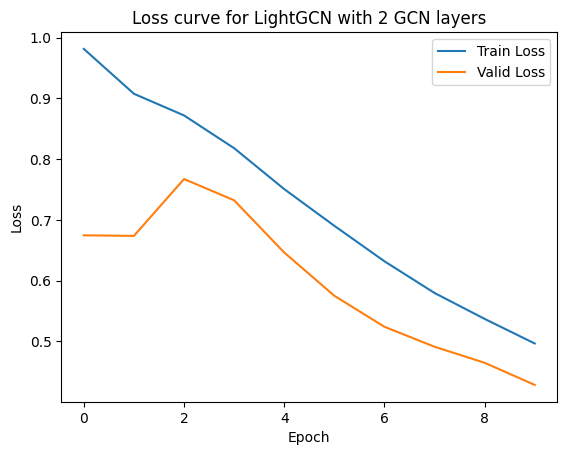

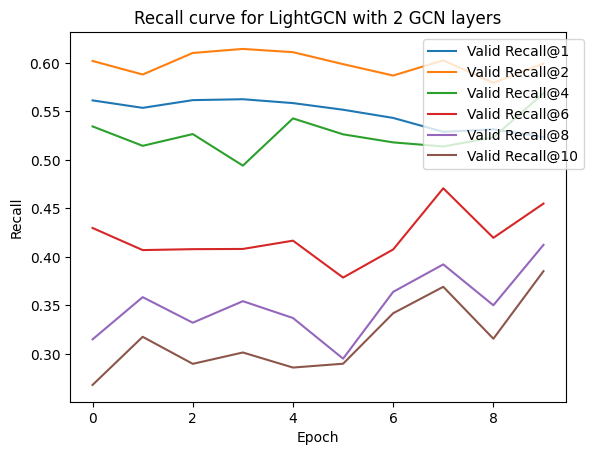

Test Loss: 0.390392541885376


100%|██████████| 10000/10000 [00:15<00:00, 648.02it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3438
Fraction of papers used for 4: 0.0539
Fraction of papers used for 6: 0.0236
Fraction of papers used for 8: 0.0161
Fraction of papers used for 10: 0.013
Recall@1: 0.5401580929756165
Recall@2: 0.5906640887260437
Recall@4: 0.5388378500938416
Recall@6: 0.43425628542900085
Recall@8: 0.3775971829891205
Recall@10: 0.3484400808811188
Number of layers: 4
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.9626247882843018
Valid Loss: 0.6701681017875671


 10%|█         | 1/10 [00:21<03:09, 21.06s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3366
Fraction of papers used for 4: 0.0578
Fraction of papers used for 6: 0.0256
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.0142
Recall@10: {1: 0.57369447, 2: 0.6057956, 4: 0.51121676, 6: 0.39786938, 8: 0.3170335, 10: 0.26514262}
Epoch: 1
Loss: 0.8657918572425842
Valid Loss: 0.6821882724761963


 20%|██        | 2/10 [00:42<02:49, 21.23s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3414
Fraction of papers used for 4: 0.0532
Fraction of papers used for 6: 0.0236
Fraction of papers used for 8: 0.0144
Fraction of papers used for 10: 0.0104
Recall@10: {1: 0.5686462, 2: 0.6224414, 4: 0.5239013, 6: 0.45500147, 8: 0.35515648, 10: 0.25832832}
Epoch: 2
Loss: 0.8614468574523926
Valid Loss: 0.8454146385192871


 30%|███       | 3/10 [01:04<02:30, 21.44s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3322
Fraction of papers used for 4: 0.051
Fraction of papers used for 6: 0.0224
Fraction of papers used for 8: 0.0154
Fraction of papers used for 10: 0.0116
Recall@10: {1: 0.5688483, 2: 0.60112035, 4: 0.53237903, 6: 0.42072767, 8: 0.37916806, 10: 0.31388402}
Epoch: 3
Loss: 0.767991840839386
Valid Loss: 0.7118279337882996


 40%|████      | 4/10 [01:25<02:09, 21.55s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.354
Fraction of papers used for 4: 0.0562
Fraction of papers used for 6: 0.0254
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0144
Recall@10: {1: 0.5616454, 2: 0.60406214, 4: 0.53081375, 6: 0.39487135, 8: 0.29215267, 10: 0.2769707}
Epoch: 4
Loss: 0.696415901184082
Valid Loss: 0.5926547050476074


 50%|█████     | 5/10 [01:47<01:47, 21.59s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3464
Fraction of papers used for 4: 0.0586
Fraction of papers used for 6: 0.027
Fraction of papers used for 8: 0.0168
Fraction of papers used for 10: 0.0132
Recall@10: {1: 0.5456311, 2: 0.58620954, 4: 0.5157184, 6: 0.4484876, 8: 0.33872604, 10: 0.28692862}
Epoch: 5
Loss: 0.636604368686676
Valid Loss: 0.514732301235199


 60%|██████    | 6/10 [02:09<01:26, 21.66s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3404
Fraction of papers used for 4: 0.0578
Fraction of papers used for 6: 0.0278
Fraction of papers used for 8: 0.0188
Fraction of papers used for 10: 0.0152
Recall@10: {1: 0.54476464, 2: 0.6057705, 4: 0.51713914, 6: 0.4190603, 8: 0.34378457, 10: 0.30785552}
Epoch: 6
Loss: 0.5736536979675293
Valid Loss: 0.46125689148902893


 70%|███████   | 7/10 [02:30<01:04, 21.63s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3504
Fraction of papers used for 4: 0.0574
Fraction of papers used for 6: 0.025
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0138
Recall@10: {1: 0.5388029, 2: 0.59919286, 4: 0.5509206, 6: 0.43543208, 8: 0.3460206, 10: 0.3091038}
Epoch: 7
Loss: 0.5158880352973938
Valid Loss: 0.43246251344680786


 80%|████████  | 8/10 [02:51<00:42, 21.47s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3412
Fraction of papers used for 4: 0.0512
Fraction of papers used for 6: 0.0234
Fraction of papers used for 8: 0.0146
Fraction of papers used for 10: 0.0124
Recall@10: {1: 0.55056643, 2: 0.5988209, 4: 0.54812086, 6: 0.4642126, 8: 0.36978406, 10: 0.37876278}
Epoch: 8
Loss: 0.4674186706542969
Valid Loss: 0.4200598895549774


 90%|█████████ | 9/10 [03:12<00:21, 21.32s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3424
Fraction of papers used for 4: 0.0544
Fraction of papers used for 6: 0.0256
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0146
Recall@10: {1: 0.5410552, 2: 0.590141, 4: 0.53353256, 6: 0.44131362, 8: 0.35810485, 10: 0.3634252}
Epoch: 9
Loss: 0.42112216353416443
Valid Loss: 0.4052664339542389


100%|██████████| 10/10 [03:34<00:00, 21.43s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3504
Fraction of papers used for 4: 0.0584
Fraction of papers used for 6: 0.0264
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0128
Recall@10: {1: 0.5643555, 2: 0.6100056, 4: 0.5475377, 6: 0.47511742, 8: 0.41604856, 10: 0.3370595}


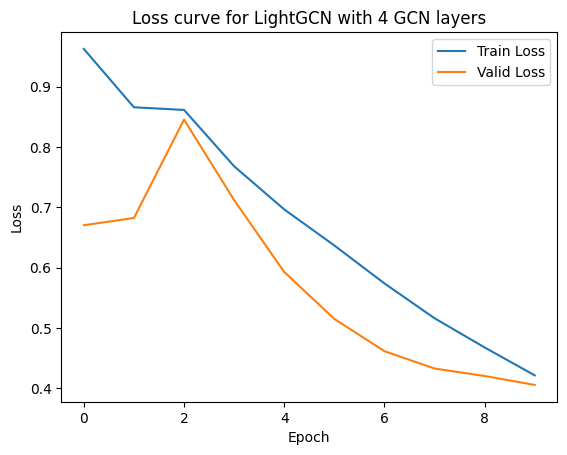

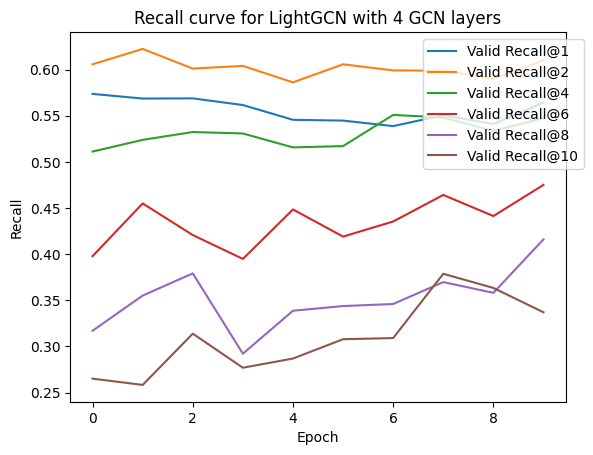

Test Loss: 0.39308100938796997


100%|██████████| 10000/10000 [00:14<00:00, 669.18it/s]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3496
Fraction of papers used for 4: 0.0569
Fraction of papers used for 6: 0.0237
Fraction of papers used for 8: 0.0155
Fraction of papers used for 10: 0.0128
Recall@1: 0.5717759728431702
Recall@2: 0.6209403872489929
Recall@4: 0.5683524012565613
Recall@6: 0.4636026918888092
Recall@8: 0.3668070435523987
Recall@10: 0.355257123708725
Number of layers: 8
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Loss: 0.8829673528671265
Valid Loss: 0.676910400390625


 10%|█         | 1/10 [00:28<04:18, 28.74s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3508
Fraction of papers used for 4: 0.0552
Fraction of papers used for 6: 0.0266
Fraction of papers used for 8: 0.0168
Fraction of papers used for 10: 0.0132
Recall@10: {1: 0.5693295, 2: 0.60576683, 4: 0.5123919, 6: 0.4062304, 8: 0.33729348, 10: 0.29857513}
Epoch: 1
Loss: 0.8314630389213562
Valid Loss: 0.789898157119751


 20%|██        | 2/10 [00:58<03:52, 29.10s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3396
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.0256
Fraction of papers used for 8: 0.0178
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.57111007, 2: 0.60085106, 4: 0.50302386, 6: 0.4193685, 8: 0.37483057, 10: 0.32595643}
Epoch: 2
Loss: 0.7324928641319275
Valid Loss: 0.6580181121826172


 30%|███       | 3/10 [01:28<03:29, 29.89s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3492
Fraction of papers used for 4: 0.055
Fraction of papers used for 6: 0.0224
Fraction of papers used for 8: 0.0138
Fraction of papers used for 10: 0.0108
Recall@10: {1: 0.56351995, 2: 0.6125968, 4: 0.5487798, 6: 0.41289464, 8: 0.31530032, 10: 0.27666068}
Epoch: 3
Loss: 0.646930456161499
Valid Loss: 0.5510241985321045


 40%|████      | 4/10 [01:58<02:59, 29.86s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3448
Fraction of papers used for 4: 0.0554
Fraction of papers used for 6: 0.0244
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0124
Recall@10: {1: 0.5584072, 2: 0.6118984, 4: 0.55601156, 6: 0.4669937, 8: 0.3479266, 10: 0.3156422}
Epoch: 4
Loss: 0.5674479007720947
Valid Loss: 0.475739985704422


 50%|█████     | 5/10 [02:28<02:28, 29.67s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3226
Fraction of papers used for 4: 0.052
Fraction of papers used for 6: 0.0238
Fraction of papers used for 8: 0.0166
Fraction of papers used for 10: 0.014
Recall@10: {1: 0.55320334, 2: 0.6026482, 4: 0.51929396, 6: 0.4123969, 8: 0.35735714, 10: 0.34951293}
Epoch: 5
Loss: 0.4954368472099304
Valid Loss: 0.41862955689430237


 60%|██████    | 6/10 [02:57<01:58, 29.59s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.341
Fraction of papers used for 4: 0.0474
Fraction of papers used for 6: 0.0212
Fraction of papers used for 8: 0.015
Fraction of papers used for 10: 0.0114
Recall@10: {1: 0.54302794, 2: 0.60169524, 4: 0.5311628, 6: 0.46848804, 8: 0.4089473, 10: 0.346537}
Epoch: 6
Loss: 0.4214811325073242
Valid Loss: 0.3665136396884918


 70%|███████   | 7/10 [03:26<01:28, 29.41s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3562
Fraction of papers used for 4: 0.06
Fraction of papers used for 6: 0.0296
Fraction of papers used for 8: 0.0214
Fraction of papers used for 10: 0.017
Recall@10: {1: 0.56836945, 2: 0.61906123, 4: 0.5444544, 6: 0.4515809, 8: 0.40735894, 10: 0.38329715}
Epoch: 7
Loss: 0.3587002754211426
Valid Loss: 0.36164048314094543


 80%|████████  | 8/10 [03:55<00:58, 29.37s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3458
Fraction of papers used for 4: 0.0538
Fraction of papers used for 6: 0.0234
Fraction of papers used for 8: 0.017
Fraction of papers used for 10: 0.0138
Recall@10: {1: 0.58767146, 2: 0.6234051, 4: 0.5455875, 6: 0.4309502, 8: 0.40187177, 10: 0.3751267}
Epoch: 8
Loss: 0.34587720036506653
Valid Loss: 0.4444182813167572


 90%|█████████ | 9/10 [04:24<00:29, 29.24s/it]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3338
Fraction of papers used for 4: 0.0586
Fraction of papers used for 6: 0.0284
Fraction of papers used for 8: 0.0206
Fraction of papers used for 10: 0.0168
Recall@10: {1: 0.5887768, 2: 0.6240348, 4: 0.51411295, 6: 0.44170246, 8: 0.40173444, 10: 0.38150057}
Epoch: 9
Loss: 0.32656240463256836
Valid Loss: 0.4624323844909668


100%|██████████| 10/10 [04:54<00:00, 29.40s/it]


Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3444
Fraction of papers used for 4: 0.058
Fraction of papers used for 6: 0.026
Fraction of papers used for 8: 0.0176
Fraction of papers used for 10: 0.0142
Recall@10: {1: 0.5932946, 2: 0.6278464, 4: 0.56068957, 6: 0.4751108, 8: 0.42323706, 10: 0.40133104}


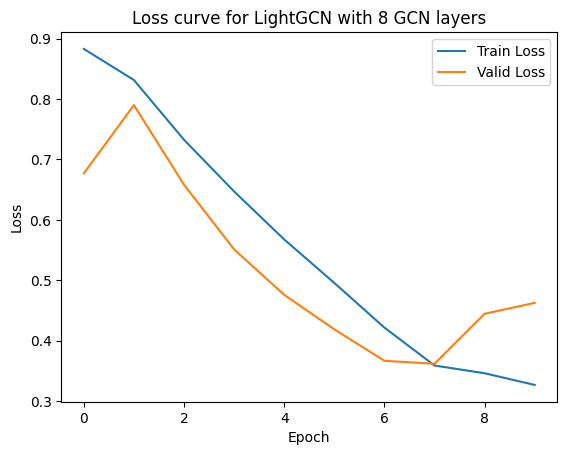

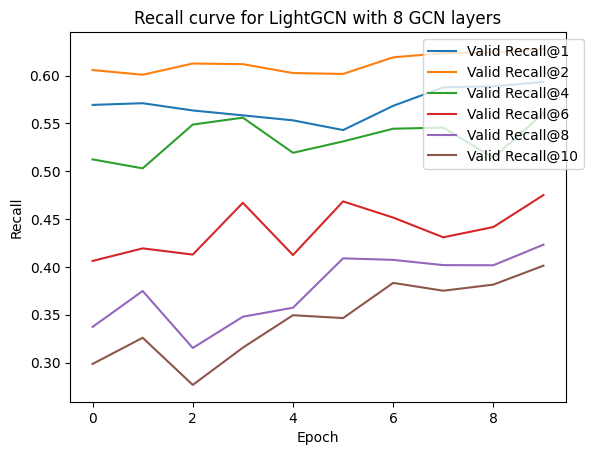

Test Loss: 0.4092421531677246


100%|██████████| 10000/10000 [00:15<00:00, 665.90it/s]

Fraction of papers used for 1: 1.0
Fraction of papers used for 2: 0.3461
Fraction of papers used for 4: 0.0529
Fraction of papers used for 6: 0.0249
Fraction of papers used for 8: 0.0162
Fraction of papers used for 10: 0.0122
Recall@1: 0.5970781445503235
Recall@2: 0.6460314989089966
Recall@4: 0.5695235133171082
Recall@6: 0.4997239410877228
Recall@8: 0.4344768822193146
Recall@10: 0.38347718119621277


In [ ]:
num_layers_list=[1 ,2 ,4 ,8]
for num_layers in num_layers_list:
  print(f"Number of layers: {num_layers}")
  print("Training...")

  # model
  model = LightGCN2(None, num_author, feat_dim, 64, num_layers)
  # optimizer
  optimizer = t.optim.Adam(model.parameters(), lr=0.005)
  train_loss = []
  valid_loss = []
  valid_recall = {
      1: [],
      2: [],
      4: [],
      6: [],
      8: [],
      10: []
  }

  # train
  for epoch in tqdm(range(10)):
      print(f"Epoch: {epoch}")
      model.train()
      optimizer.zero_grad()
      author_embeddings, paper_embeddings = model(train_graph, paper_feat)

      # convert pos and neg ids to embeddings
      similar_author_embeddings_1=author_embeddings[positive_author_pairs[:,0]]
      similar_author_embeddings_2=author_embeddings[positive_author_pairs[:,1]]
      pos_author_embeddings = author_embeddings[train_pos_u]
      pos_paper_embeddings = paper_embeddings[train_pos_v]
      neg_author_embeddings = author_embeddings[train_neg_u]
      neg_paper_embeddings = paper_embeddings[train_neg_v]

      # BPR loss
      pos_score = t.sum(pos_author_embeddings * pos_paper_embeddings, dim=1)
      neg_score = t.sum(neg_author_embeddings * neg_paper_embeddings, dim=1)
      # add similar author score: dot product of embeddings of similar authors. augment the loss function with this score.
      # the model will try to bring these similar authors closer, so that these authors are recommended more during the co-author prediction task.
      sim_author_score=t.sum(similar_author_embeddings_1 * similar_author_embeddings_2, dim=1)
      loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))-t.mean(t.log(t.sigmoid(sim_author_score)))/2

      loss.backward()
      optimizer.step()
      print(f"Loss: {loss.item()}")
      train_loss.append(loss.item())

      # validation
      model.eval()
      with t.no_grad():
          # cosine similarity
          pos_score = t.sum(author_embeddings[valid_pos_u] * paper_embeddings[valid_pos_v], dim=1)
          neg_score = t.sum(author_embeddings[valid_neg_u] * paper_embeddings[valid_neg_v], dim=1)
          loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))

          valid_loss.append(loss.item())
          print(f"Valid Loss: {loss.item()}")
          val_sample = random.sample(range(valid_papers.shape[0]), 5000)
          recK = recallK(valid_papers[val_sample], pos_score, valid_pos_v, neg_score, valid_neg_v, list(valid_recall.keys()))
          for k in valid_recall.keys():
              valid_recall[k].append(recK[k])
          print(f"Recall@{k}: {recK}")

  # plot loss
  plt.plot(train_loss, label='Train Loss')
  plt.plot(valid_loss, label='Valid Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Loss curve for LightGCN with {num_layers} GCN layers')
  plt.legend()
  plt.savefig(f'Augmented_loss_{num_layers}.png')
  plt.show()
  plt.clf()
  for k in valid_recall.keys():
      plt.plot(valid_recall[k], label=f'Valid Recall@{k}')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.title(f'Recall curve for LightGCN with {num_layers} GCN layers')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
  plt.savefig(f'Augmented_recall_{num_layers}.png')
  plt.show()

  # test
  model.eval()
  with t.no_grad():
      # recall K
      author_embeddings, paper_embeddings = model(valid_graph, paper_feat)
      # cosine similarity
      pos_score = t.sum(author_embeddings[test_pos_u] * paper_embeddings[test_pos_v], dim=1)
      neg_score = t.sum(author_embeddings[test_neg_u] * paper_embeddings[test_neg_v], dim=1)
      loss = -t.mean(t.log(t.sigmoid(pos_score - neg_score)))
      print(f"Test Loss: {loss.item()}")
      test_sample = random.sample(range(test_papers.shape[0]), min(10000, test_papers.shape[0]))
      recK = recallK(test_papers[test_sample], pos_score, test_pos_v, neg_score, test_neg_v, list(valid_recall.keys()))
      for k in valid_recall.keys():
          print(f"Recall@{k}: {recK[k]}")